/tmp/ipykernel_186221/1242208575.py:20: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


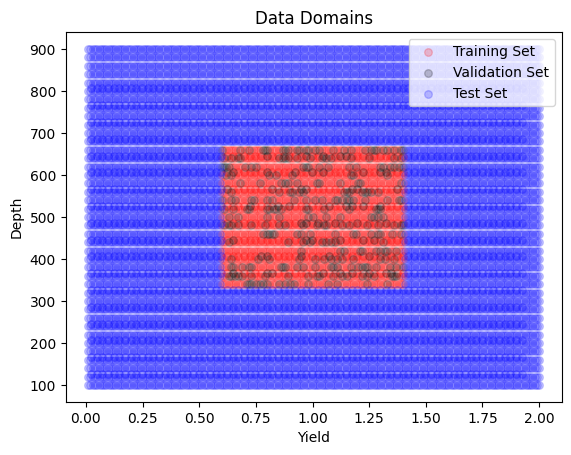

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Aug 29 15:39:51 2023

This script trains PINN model for TDSF supplied by AFTAC-CRADA
Inputs: yield (w), depth (h), time (t)
Output: displacement (S)

@author: shhong
"""

#%% Load Moduels

import os
root = os.path.abspath('')
# root = '/home/ubuntu/tdsf'

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import scipy.io as sio
import matplotlib.pyplot as plt

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from timeit import default_timer as timer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# from sklearn.metrics import confusion_matrix
# from sklearn.preprocessing import OneHotEncoder

# device = torch.device('cuda:0')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

study = 'noise_study_ood_domain_no_phy_smaller' # noise_study_ood_phy_domain_sampled

#%% Load Data

# path = 'E:\Hong\Research Projects\PINN\Data'
path = f'{root}/data'

filename = 'tdsf_002_train.pickle'
df_train_all = pd.read_pickle(path + '/' + filename)

filename = 'tdsf_002_val.pickle'
df_test_all = pd.read_pickle(path + '/' + filename)

df_data_all = pd.concat([df_train_all, df_test_all], axis=0)


#%% Select Material

# [Tuff-Rhyolite, Granite, Shale, Salt, Wet-Granite, Wet-Tuff]

name_prefix = '_FAR.'
name_material = 'Tuff-Rhyolite'

df_data = df_data_all[df_data_all['material'] == name_prefix + name_material]
df_data = df_data.reset_index(drop=True)

# round YIELD and DEPTH to 2 decimal places
df_data.YIELD = df_data.YIELD.round(2)
df_data.DEPTH = df_data.DEPTH.round(2)

# splits df into train and test by yield and depth quantiles
qnts = [.7, .3]
ylds, dpths = df_data.YIELD.quantile(qnts, interpolation='nearest'), df_data.DEPTH.quantile(qnts, interpolation='nearest')
train_qnt = (df_data.YIELD >= ylds.min()) & (df_data.YIELD <= ylds.max()) & (df_data.DEPTH >= dpths.min()) & (df_data.DEPTH <= dpths.max())

# split data into train and test by domain (inner and outer)
df_train = df_data[train_qnt].reset_index(drop=True)
df_test = df_data[~train_qnt].reset_index(drop=True)

# split train into train and validation, randomly selected from the inner domain
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=0)
df_train, df_val = df_train.reset_index(drop=True), df_val.reset_index(drop=True)


# plot train and test yields and depths
s = 30
plt.figure()
plt.scatter(df_train.YIELD, df_train.DEPTH, label='Training Set', color='red', alpha=0.2, s=s)
plt.scatter(df_val.YIELD, df_val.DEPTH, label='Validation Set', color='black', alpha=0.2, s=s)
plt.scatter(df_test.YIELD, df_test.DEPTH, label='Test Set', color='blue', alpha=0.2, s=s)
plt.xlabel('Yield')
plt.ylabel('Depth')
plt.legend()
plt.title('Data Domains')
plt.savefig(f'{root}/results/{study}/domains.png')
# plt.close('all')
plt.show()


In [2]:

#%% Data Arrangement

trunc = 1000
ds = 10
dt = 0.001

tv = np.arange(1,trunc+1)*dt
tv = tv[::ds]

# Define Train Set
tdsf = df_train.DATA
wvec = df_train.YIELD
hvec = df_train.DEPTH
t_tdsf = tdsf[0][:trunc]
Xtrain = np.concatenate((wvec[0]*np.ones((tv.size,1)), hvec[0]*np.ones((tv.size,1)), np.reshape(tv,(-1,1))), axis=1)
Ytrain = np.reshape(t_tdsf[::ds], (-1,1))
for ndx in range(1, df_train.shape[0]):
    t_tdsf = tdsf[ndx][:trunc]
    Xtemp = np.concatenate((wvec[ndx]*np.ones((tv.size,1)), hvec[ndx]*np.ones((tv.size,1)), np.reshape(tv,(-1,1))), axis=1)        
    Xtrain = np.concatenate((Xtrain, Xtemp), axis=0)
    Ytrain = np.concatenate((Ytrain, np.reshape(t_tdsf[::ds], (-1,1))), axis=0)
Xtrain = Xtrain.astype(np.float32)
Ytrain = Ytrain.astype(np.float32)

# Define Val Set
tdsf = df_val.DATA
wvec = df_val.YIELD
hvec = df_val.DEPTH
t_tdsf = tdsf[0][:trunc]
Xval = np.concatenate((wvec[0]*np.ones((tv.size,1)), hvec[0]*np.ones((tv.size,1)), np.reshape(tv,(-1,1))), axis=1)
Yval = np.reshape(t_tdsf[::ds], (-1,1))
for ndx in range(1, df_val.shape[0]):
    t_tdsf = tdsf[ndx][:trunc]
    Xtemp = np.concatenate((wvec[ndx]*np.ones((tv.size,1)), hvec[ndx]*np.ones((tv.size,1)), np.reshape(tv,(-1,1))), axis=1)        
    Xval = np.concatenate((Xval, Xtemp), axis=0)
    Yval = np.concatenate((Yval, np.reshape(t_tdsf[::ds], (-1,1))), axis=0)
Xval = Xval.astype(np.float32)
Yval = Yval.astype(np.float32)

# Define Test Set
tdsf = df_test.DATA
wvec = df_test.YIELD
hvec = df_test.DEPTH
t_tdsf = tdsf[0][:trunc]
Xtest = np.concatenate((wvec[0]*np.ones((tv.size,1)), hvec[0]*np.ones((tv.size,1)), np.reshape(tv,(-1,1))), axis=1)
Ytest = np.reshape(t_tdsf[::ds], (-1,1))
for ndx in range(1, df_test.shape[0]):
    t_tdsf = tdsf[ndx][:trunc]
    Xtemp = np.concatenate((wvec[ndx]*np.ones((tv.size,1)), hvec[ndx]*np.ones((tv.size,1)), np.reshape(tv,(-1,1))), axis=1)        
    Xtest = np.concatenate((Xtest, Xtemp), axis=0)
    Ytest = np.concatenate((Ytest, np.reshape(t_tdsf[::ds], (-1,1))), axis=0)
Xtest = Xtest.astype(np.float32)
Ytest = Ytest.astype(np.float32)


#%% Preprocessing

# Min-Max Normalization
Xscaler = MinMaxScaler()
Xscaler.fit(np.vstack([Xtrain, Xval, Xtest]))
MaxX = Xscaler.data_max_
MinX = Xscaler.data_min_

Yscaler = MinMaxScaler()
Yscaler.fit(np.vstack([Ytrain, Yval, Ytest]))
MaxY = Yscaler.data_max_
MinY = Yscaler.data_min_

Ztrain = Yscaler.transform(Ytrain)
Zval = Yscaler.transform(Yval)
Ztest = Yscaler.transform(Ytest)

# Shuffle Data
numdata = Xtrain.shape[0]
Ztrain_base = Ztrain.copy()


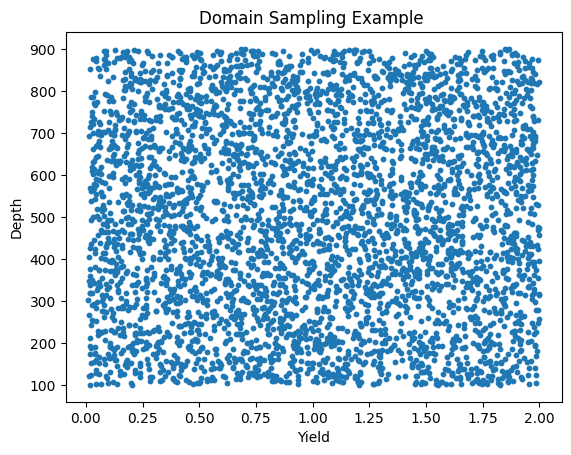

In [3]:
# randomly sample w,h,t between their min and max values
n = 4096

w = np.random.uniform(MinX[0], MaxX[0], n)
h = np.random.uniform(MinX[1], MaxX[1], n)
t = np.random.uniform(MinX[2], MaxX[2], n)
Xsample = np.vstack([w, h, t]).T



# plot h vs w for the sampled data
plt.figure()
plt.scatter(w, h, s=10)
plt.xlabel('Yield')
plt.ylabel('Depth')
plt.title('Domain Sampling Example ')
plt.savefig(f'{root}/results/{study}/sampled_data.png')


In [6]:
noise = [0.00, 0.2, 0.5]
for sigma in noise:

    path = f'{root}/results/{study}/{sigma}'
    if not os.path.exists(path): os.makedirs(path)
    else:
        print(f'{root}/results/{study}/{sigma} exists, skipping')
        continue

    # Gaussian Noise
    # sigma = 0.00
    mu = 0.00
    np.random.seed(1)
    Ztrain = (Ztrain_base + sigma*np.random.randn(numdata,1) + mu).astype(np.float32)

    numIn = Xtrain.shape[1]
    numOut = Ztrain.shape[1]


    #%% Define Classes

    class ANN_Dataset(Dataset):    

        # Initialize your data
        def __init__(self, x, y):        
            self.len = x.shape[0]
            self.x_data = torch.from_numpy(x)
            self.y_data = torch.from_numpy(y)

        def __getitem__(self, index):
            return self.x_data[index], self.y_data[index]

        def __len__(self):
            return self.len


    # Fully Connected NN
    class FCNN_Net(nn.Module):

        def __init__(self, numIn, numOut):
            super(FCNN_Net, self).__init__()
            self.fc1 = nn.Linear(numIn, 128)
            self.fc2 = nn.Linear(128, 6)
            self.fc3 = nn.Linear(6, numOut)
            
        def forward(self, w, h, t):        
            inputs = torch.cat([w,h,t],axis=1) # combined two arrays of 1 columns each to one array of 2 columns        
            # in_size = x.size(0)
            # inputs = x.view(in_size, -1)
            layer1_out = torch.tanh(self.fc1(inputs))
            layer2_out = torch.tanh(self.fc2(layer1_out))
            output = (self.fc3(layer2_out))
            return output


    #%% Defined Functions


    ## PDE as loss function. Thus would use the network which we call as u_theta
    def f_partial(data, net, MaxX, MinX, MaxY, MinY):
        
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        xmax = torch.from_numpy(MaxX).to(device)
        xmin = torch.from_numpy(MinX).to(device)
        ymax = torch.from_numpy(MaxY).to(device)
        ymin = torch.from_numpy(MinY).to(device)
        
        wvec = Variable(torch.reshape(data[:,0], (-1,1)), requires_grad=True).to(device)
        hvec = Variable(torch.reshape(data[:,1], (-1,1)), requires_grad=True).to(device)
        tvec = Variable(torch.reshape(data[:,2], (-1,1)), requires_grad=True).to(device)
            
        # applying normalized input
        # x = torch.cat([(wvec-xmin[0])/(xmax[0]-xmin[0]),(hvec-xmin[1])/(xmax[1]-xmin[1]),(tvec-xmin[2])/(xmax[2]-xmin[2])],axis=1)    
        s = net((wvec-xmin[0])/(xmax[0]-xmin[0]), (hvec-xmin[1])/(xmax[1]-xmin[1]), (tvec-xmin[2])/(xmax[2]-xmin[2])) # the dependent variable s is given by the network based on independent variables w, h, t

        # remove normalization
        s = s*(ymax-ymin) + ymin
        
        s_w = torch.autograd.grad(s.sum(), wvec, create_graph=True)[0]
        s_h = torch.autograd.grad(s.sum(), hvec, create_graph=True)[0] 
            
        ww = torch.reshape(data[:,0], (-1,1))
        hh = torch.reshape(data[:,1], (-1,1))
        tt = torch.reshape(data[:,2], (-1,1))
        
        # define parameters
        ho = 122
        Ro = 202
        go = 26
        P1 = 3.6*1e6
        P2 = 5.0*1e6
        n = 2.4
        pv = 3500
        sv = 2021
        rho = 2000
        
        dsdR = torch.zeros(ww.shape).to(device)

        Rel = Ro*((ho/hh)**(1/n))*(ww**(1/3))
        ga = go*Ro/Rel

        mu = rho*(sv**2)
        lam = rho*(pv**2)-2*mu    
        wo = pv/Rel
        bet = (lam+2*mu)/(4*mu)
        alp = wo/(2*bet)
        p = wo*(1/2/bet-1/4/bet**2)**(1/2)

        def dF_(tau):
            return (Rel*pv**2)/(4*mu*bet*p)*(-alp*torch.exp(-alp*tau)*torch.sin(p*tau) + p*torch.exp(-alp*tau)*torch.cos(p*tau))

        def dBdR_(tau):
            return (tt-tau)*ga*torch.exp(-ga*(tt-tau))/Rel*P1*(hh/ho) - ((tt-tau)*ga*torch.exp(-ga*(tt-tau))+3*(1-torch.exp(-ga*(tt-tau))))/Rel*P2*((ho/hh)**(1/3))*((Ro/Rel)**3)*(ww**(0.87))

        dtau = 0.001
        tau = torch.tensor(np.arange(0,1,dtau)).to(device).float()
        
        dF = dF_(tau)
        dBdR = dBdR_(tau)
        
        temp = dF*dBdR*dtau
        mask = (tt - tau) < 0
        temp[mask] = 0
        dsdR += temp.sum(axis=-1).unsqueeze(-1)

        dRdw = 1/3*Ro*((ho/hh)**(1/n))*(ww**(-2/3))
        dRdh = -1/n*((ho/hh)**(1/n))*(1/hh)*(ww**(1/3))
        dsdw = dsdR*dRdw
        dsdh = dsdR*dRdh
            
        return s_w, dsdw, s_h, dsdh


    def train(model, loader, optimizer, MaxX, MinX, MaxY, MinY, lam1, lam2):
        
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        model.train()
        total_loss = 0
        
        xmax = torch.from_numpy(MaxX).to(device)
        xmin = torch.from_numpy(MinX).to(device)
        
        for batch_idx, (data, target) in enumerate(loader):

            
            # get a batch of unnormlized data
            data, target = Variable(data, requires_grad=True).to(device), Variable(target, requires_grad=True).to(device)

            # create Y-D domain mask for data loss
            mask = (data[:,0] >= ylds.min()) & (data[:,0] <= ylds.max()) & (data[:,1] >= dpths.min()) & (data[:,1] <= dpths.max())

            
            # normalization
            dataN = (data-xmin)/(xmax-xmin)
                    
            def closure():
                optimizer.zero_grad()
                output = model(torch.reshape(dataN[:,0], (-1,1)), torch.reshape(dataN[:,1], (-1,1)), torch.reshape(dataN[:,2], (-1,1)))
                
                # mask the output and target in the data loss calculation
                mse_d = criterion(output[mask],target[mask])   
                
                loss = mse_d 

                loss.backward()
                return loss
            
            loss = optimizer.step(closure=closure)
            total_loss += loss.item()
        
        total_loss /= len(loader.dataset)
        
        return total_loss
        

    def test(model, loader, MaxX, MinX, MaxY, MinY):
        
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        model.eval()
        test_loss = 0
        
        xmax = torch.from_numpy(MaxX).to(device)
        xmin = torch.from_numpy(MinX).to(device)
        
        for data, target in loader:

            data = data.requires_grad_(False).to(device)
            target = target.requires_grad_(False).to(device)
            
            # normalization
            dataN = (data-xmin)/(xmax-xmin)
            
            output = model(torch.reshape(dataN[:,0], (-1,1)), torch.reshape(dataN[:,1], (-1,1)), torch.reshape(dataN[:,2], (-1,1)))
            
            loss = criterion(output,target)
            test_loss += loss.item()
            # print(len(data))

        test_loss /= len(loader.dataset)

        return test_loss


    #%% Hyperparameter Selection

    max_epoch = 1000
    max_fail = 8
    batch_size = 4096


    lamda1 = 1e-9 # PDE loss weight
    lamda2 = 1.


    train_dataset = ANN_Dataset(Xtrain, Ztrain)
    val_dataset = ANN_Dataset(Xval, Zval)
    test_dataset = ANN_Dataset(Xtest, Ztest)

    # Data Loader (Input Pipeline)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    #%% Training

    # Define Network to Train
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = FCNN_Net(numIn, numOut).to(device)
    # model.double()

    # Select Optimizer and Loss Criterion
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                            weight_decay=0, amsgrad=False)

    fail_count = 0
    min_cost = float('inf')

    timevec = np.zeros((max_epoch, 1))
    losses = {'train': [], 'val': [], 'test': []}
    
    for epoch in range(1, max_epoch):
        
        start = timer()    
        RMSE_train_DP = np.sqrt(train(model, train_loader, optimizer, MaxX, MinX, MaxY, MinY, lamda1, lamda2))
        RMSE_train_D = np.sqrt(test(model, train_loader, MaxX, MinX, MaxY, MinY))
        RMSE_val = np.sqrt(test(model, val_loader, MaxX, MinX, MaxY, MinY))
        RMSE_test = np.sqrt(test(model, test_loader, MaxX, MinX, MaxY, MinY))

        losses['train'].append(RMSE_train_D)
        losses['val'].append(RMSE_val)
        losses['test'].append(RMSE_test)

        print(f'Epoch: {epoch} Trn (D+P) {RMSE_train_DP:.8f} | Trn (D) {RMSE_train_D:.8f} | Val {RMSE_val:.8f} | Tst {RMSE_test:.8f}')
            
        if RMSE_val < min_cost:
            min_cost = RMSE_val
            fail_count = 0
        elif fail_count >= max_fail:
            print('Stopping... Maximum number of validation failures exceeded')
            break
        else:
            fail_count += 1
                
        timevec[epoch] = timer() - start
            
    time_avg = timevec[:epoch].mean()
    print('Average time taken for a single epoch is %f seconds.' % time_avg)

    #%% Plot Results

    plt.plot(losses['train'], 'b')
    plt.plot(losses['val'], 'r')
    plt.plot(losses['test'], 'g')
    plt.xlabel('epoch')
    plt.ylabel('RMSE')
    plt.legend(('train', 'val', 'test'))
    plt.savefig(path + '/losses.png')
    plt.close('all')



    model.to('cpu')
    model.eval()

    # validation set
    Xin = (Xval-MinX)/(MaxX-MinX)
    Xt = torch.from_numpy(Xin)
    Zhat = model(torch.reshape(Xt[:,0], (-1,1)), torch.reshape(Xt[:,1], (-1,1)), torch.reshape(Xt[:,2], (-1,1)))
    Zhat = Zhat.detach().numpy()
    Yhat_val = Yscaler.inverse_transform(Zhat)


    # train set
    Xin = (Xtrain-MinX)/(MaxX-MinX)
    Xt = torch.from_numpy(Xin)
    Zhat = model(torch.reshape(Xt[:,0], (-1,1)), torch.reshape(Xt[:,1], (-1,1)), torch.reshape(Xt[:,2], (-1,1)))
    Zhat = Zhat.detach().numpy()
    Yhat_train = Yscaler.inverse_transform(Zhat)

    
    line = np.arange(0, MaxY, 1e-4)
    plt.plot(Yval[:,0], Yhat_val[:,0], 'bo')
    plt.plot(line, line, 'k')
    plt.xlabel('true')
    plt.ylabel('predicted')
    plt.title('displacement')
    plt.savefig(path + '/disp_true_v_pred_val.png')
    # plt.show()
    plt.close('all')

    # test set
    Xin = (Xtest-MinX)/(MaxX-MinX)
    Xt = torch.from_numpy(Xin)
    Zhat = model(torch.reshape(Xt[:,0], (-1,1)), torch.reshape(Xt[:,1], (-1,1)), torch.reshape(Xt[:,2], (-1,1)))
    Zhat = Zhat.detach().numpy()
    Yhat_test = Yscaler.inverse_transform(Zhat)


    line = np.arange(0, MaxY, 1e-4)
    plt.plot(Ytest[:,0], Yhat_test[:,0], 'bo')
    plt.plot(line, line, 'k')
    plt.xlabel('true')
    plt.ylabel('predicted')
    plt.title('displacement')
    plt.savefig(path + '/disp_true_v_pred_test.png')
    # plt.show()
    plt.close('all')



    plt.plot(Xtest[:,2], Yhat_test[:,0], 'bo')
    plt.plot(Xtest[:,2], Ytest[:,0], 'r')
    plt.xlabel('time')
    plt.ylabel('displacement')
    plt.savefig(path + '/disp_err_v_time.png')
    # plt.show()
    plt.close('all')




    #%% Save Data and Model

    # v1: lamda1 = 1e-9, lamda2 = 1 (noise 0) RMSE: 0.0001379581


    modelname = 'SeismicWave_TDSF_forward_PGNN_v1.pth'
    ANNmodel = {'model': FCNN_Net(numIn, numOut),
            'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict()}
    torch.save(ANNmodel, path + '/' + modelname)


    filename = f'{path}/SeismicWave_TDSF_forward_PGNN_v1_result.mat'
    sio.savemat(filename, 
            {
            'Yhat_train':Yhat_train, 'Ytrain':Ytrain, 'Xtrain':Xtrain,
            'Yhat_test':Yhat_test, 'Ytest':Ytest, 'Xtest':Xtest, 
            'Yhat_val':Yhat_val,'Yval':Yval, 'Xval':Xval,
            'Ymax':MaxY, 'Ymin':MinY, 'Xmax':MaxX, 'Xmin':MinX
            })

    #%% Result Comparison

    modelname = 'SeismicWave_TDSF_forward_PGNN_v1.pth'
    model_data1 = torch.load(path + '/' + modelname)

    model1 = model_data1['model']
    model1.load_state_dict(model_data1['state_dict'])
    model1.eval()


    TI = 2
    Ind1 = int((TI-1)*100)
    Ind2 = int(TI*100)
    tv = Xtest[Ind1:Ind2,2]
    Yreal = np.squeeze(Ytest[Ind1:Ind2])
    w,t = Xtest[Ind1,0], Xtest[Ind1,1]

    Xin = (Xtest-MinX)/(MaxX-MinX)

    Ztemp1 = model1(torch.from_numpy(np.reshape(Xin[Ind1:Ind2,0],(-1,1))),
                    torch.from_numpy(np.reshape(Xin[Ind1:Ind2,1],(-1,1))),
                    torch.from_numpy(np.reshape(Xin[Ind1:Ind2,2],(-1,1)))).detach().numpy()
    Ytemp1 = np.squeeze(Yscaler.inverse_transform(Ztemp1))




    #%%

    # Plot desired concentration    
    plt.plot(tv, Yreal, 'k')
    plt.plot(tv, Ytemp1, 'b')
    plt.xlabel('time')
    plt.ylabel('displacement')
    plt.legend(('Truth',f'{sigma}% Noise'))
    plt.title(f'w = {w}, h = {t}')
    plt.savefig(path + '/t_v_d.png')
    # plt.show()
    plt.close('all')



    # Plot desired concentration    
    plt.plot(tv, np.abs(Ytemp1-Yreal), 'b')
    plt.xlabel('time')
    plt.ylabel('displacement error')
    plt.legend((f'{sigma}% Noise'))
    plt.savefig(path + '/t_v_d_err.png')
    plt.close('all')
    # plt.show()




    #%% Correlation Check

    from scipy import signal
    import matplotlib.pyplot as plt

    corr1 = signal.correlate(Ytemp1, Yreal, mode='full', method='auto')
    corr1 /= np.max(corr1)
    lags1 = signal.correlation_lags(len(Ytemp1), len(Yreal))

    plt.plot(lags1, corr1, 'b')
    plt.xlabel('lags')
    plt.ylabel('cross-correlation')
    plt.legend((f'{sigma}% Noise'))
    plt.savefig(path + '/cross_corr.png')
    plt.close('all')
    # plt.show()
    



Epoch: 1 Trn (D+P) 0.00217208 | Trn (D) 0.00176667 | Val 0.00177954 | Tst 0.00174480
Epoch: 2 Trn (D+P) 0.00176952 | Trn (D) 0.00176055 | Val 0.00177473 | Tst 0.00170649
Epoch: 3 Trn (D+P) 0.00175745 | Trn (D) 0.00175659 | Val 0.00177010 | Tst 0.00170116
Epoch: 4 Trn (D+P) 0.00175654 | Trn (D) 0.00175625 | Val 0.00176988 | Tst 0.00169909
Epoch: 5 Trn (D+P) 0.00175637 | Trn (D) 0.00175629 | Val 0.00176996 | Tst 0.00170143
Epoch: 6 Trn (D+P) 0.00175658 | Trn (D) 0.00175608 | Val 0.00176963 | Tst 0.00169819
Epoch: 7 Trn (D+P) 0.00175595 | Trn (D) 0.00175547 | Val 0.00176922 | Tst 0.00169959
Epoch: 8 Trn (D+P) 0.00175611 | Trn (D) 0.00175512 | Val 0.00176875 | Tst 0.00169860
Epoch: 9 Trn (D+P) 0.00175513 | Trn (D) 0.00175521 | Val 0.00176850 | Tst 0.00169916
Epoch: 10 Trn (D+P) 0.00175460 | Trn (D) 0.00175448 | Val 0.00176792 | Tst 0.00169658
Epoch: 11 Trn (D+P) 0.00175403 | Trn (D) 0.00175347 | Val 0.00176722 | Tst 0.00169838
Epoch: 12 Trn (D+P) 0.00175347 | Trn (D) 0.00175267 | Val 0.001

In [ ]:
path